In [3]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import numpy as np
import matplotlib.dates as mdates
from pandas.tseries.offsets import DateOffset
import ast
import matplotlib.patches as mpatches

In [4]:
def load_data():
    # DETER ALERTS (GEODF)
    alerts = gpd.read_file('../data/deter-amz-public-2024out08/deter-amz-deter-public.shp', encoding='utf-8')
    alerts.loc[alerts['CLASSNAME'] == 'DEGRDACAO', 'CLASSNAME'] = 'DEGRADACAO'
    alerts = alerts[~(alerts['CLASSNAME'] == 'CORTE_SELETIVO')]
    alerts['VIEW_DATE'] = pd.to_datetime(alerts['VIEW_DATE'])
    alerts['ANO'] = alerts['VIEW_DATE'].dt.year
    alerts['MES'] = alerts['VIEW_DATE'].dt.month
    alerts['MES/ANO'] = alerts['VIEW_DATE'].dt.strftime('%Y-%m')

    # DETER ALERTS (CSV)
    df_deter = pd.DataFrame(alerts)
    df_deter = df_deter.drop(columns=['FID', 'QUADRANT', 'PATH_ROW', 'SENSOR', 'SATELLITE', 'geometry'])

    
    #IBGE DATA
    legal_amazon = gpd.read_file('../data/brazilian_legal_amazon/brazilian_legal_amazon.shp',encoding='utf-8')
    states = gpd.read_file('../data/states_legal_amazon/states_legal_amazon.shp',encoding='utf-8')
    
    ac = gpd.read_file('../data/malhas_regionais_ibge/AC_Municipios_2022/AC_Municipios_2022.shp', encoding='utf-8')
    am = gpd.read_file('../data/malhas_regionais_ibge/AM_Municipios_2022/AM_Municipios_2022.shp', encoding='utf-8')
    ap = gpd.read_file('../data/malhas_regionais_ibge/AP_Municipios_2022/AP_Municipios_2022.shp', encoding='utf-8')
    ma = gpd.read_file('../data/malhas_regionais_ibge/MA_Municipios_2022/MA_Municipios_2022.shp', encoding='utf-8')
    mt = gpd.read_file('../data/malhas_regionais_ibge/MT_Municipios_2022/MT_Municipios_2022.shp', encoding='utf-8')
    pa = gpd.read_file('../data/malhas_regionais_ibge/PA_Municipios_2022/PA_Municipios_2022.shp', encoding='utf-8')
    ro = gpd.read_file('../data/malhas_regionais_ibge/RO_Municipios_2022/RO_Municipios_2022.shp', encoding='utf-8')
    rr = gpd.read_file('../data/malhas_regionais_ibge/RR_Municipios_2022/RR_Municipios_2022.shp', encoding='utf-8')
    to = gpd.read_file('../data/malhas_regionais_ibge/TO_Municipios_2022/TO_Municipios_2022.shp', encoding='utf-8')

    df_cities = pd.concat([ac, am, ap, ma, mt, pa, ro, rr, to])
    df_cities.rename(columns={'CD_MUN':'GEOCODIBGE'}, inplace=True)

    c_units = gpd.read_file('../data/conservation_units_legal_amazon/conservation_units_legal_amazon.shp',encoding='utf-8')
    c_units.rename(columns={'nome':'UC'},inplace=True)
    
    return alerts, df_deter, legal_amazon, states, df_cities, c_units

alerts, df_deter, legal_amazon, states, df_cities, c_units = load_data()

In [5]:
# LOADING TEXTS (ENGLISH AND PORTUGUESE)

df_texts = pd.read_csv('../texts/texts_deter.csv', sep='§', engine='python')
english = {list(df_texts['Key'])[i]: list(df_texts['English'])[i] for i in range(len(list(df_texts['Key'])))}
portuguese = {list(df_texts['Key'])[i]: list(df_texts['Portuguese'])[i] for i in range(len(list(df_texts['Key'])))}

classes_deter_en = {'CICATRIZ_DE_QUEIMADA': 'Forest Fire Scar',
          'DESMATAMENTO_CR': 'Deforestation with Exposed Soil',
          'DESMATAMENTO_VEG': 'Deforestation with Vegetation',
          'MINERACAO': 'Mining',
          'DEGRADACAO': 'Degradation',
          'CS_DESORDENADO': 'Selective Logging Type 1 (Disordered)',
          'CS_GEOMETRICO': 'Selective Logging Type 2 (Geometric)',
}

classes_deter_pt = {'CICATRIZ_DE_QUEIMADA': 'Cicatriz de incêndio florestal',
          'DESMATAMENTO_CR': 'Desmatamento com solo exposto',
          'DESMATAMENTO_VEG': 'Desmatamento com Vegetação',
          'MINERACAO': 'Mineração',
          'DEGRADACAO': 'Degradação',
          'CS_DESORDENADO': 'Corte Seletivo Tipo 1 (Desordenado)',
          'CS_GEOMETRICO': 'Corte Seletivo Tipo 2 (Geométrico)',
}

estados = {
    "MT": "Mato Grosso",
    "PA": "Pará",
    "AM": "Amazonas",
    "RO": "Rondônia",
    "MA": "Maranhão",
    "RR": "Roraima",
    "AC": "Acre",
    "TO": "Tocantins",
    "AP": "Amapá"
}

def get_texts(lang):
    if lang == "English":
        return classes_deter_en, english
    else:
        return classes_deter_pt, portuguese

dict_classes, texts = get_texts("English")

In [6]:
# Pallete Generation Function
def palette_gen(n_colors=9, rgb1=[0, 100, 0], rgb2=[0, 200, 0]):
    green1 = np.array(rgb1) / 255.0
    green2 = np.array(rgb2) / 255.0
    
    grad = [green1 * (1 - i / (n_colors - 1)) + green2 * (i / (n_colors - 1)) for i in range(n_colors)]
    return [mcolors.to_hex(c) for c in grad]

gray = '#4b4d4b'

In [7]:
def save_graph(file_name,graph_func):
    fig, ax = graph_func()
    fig.savefig(f"../Visualizations/DETER/Graphs/{file_name}.png", bbox_inches='tight', pad_inches=0.1, facecolor='white')

### Graph 1:

In [8]:
# DETER GRAPH 1: TOP DETECTED CLASSES
def deter_graph1():
    df_class = df_deter.groupby('CLASSNAME')['AREAMUNKM'].sum().sort_values(ascending=False)
    df_class = pd.DataFrame(df_class)
    df_class['DESC'] = df_class.index.map(dict_classes)
    
    fig, ax = plt.subplots(figsize=(16,18))
    sns.set_theme(style="white")
    ax = sns.barplot(data=df_class, x=df_class.AREAMUNKM, y = df_class.DESC, palette=palette_gen())
    #ax.set_title(texts['title_deter_graph1'], fontsize=75, color=gray, fontweight='bold');
    #fig.suptitle(texts['title_deter_graph1'], fontsize=75, color=gray, fontweight='bold')
    ax.set_xlabel('');
    ax.set_ylabel('');
    ax.set_xticklabels([]);
    ax.yaxis.set_tick_params(labelsize=45, labelcolor = gray)
    sns.despine(left = True, bottom = True)
    
    for i, valor in enumerate(df_class.AREAMUNKM):
        p = (valor * 100) / df_class['AREAMUNKM'].sum()
        qtd = f'{valor:,.0f} km² ({p:,.2f} %)'.replace(',','.')  
        #offset = 1e3  # offset de 1.000
        ax.text(valor + 50000, i, qtd, color= gray, fontsize=45, fontweight='bold', ha='right', va='center')

    return fig, ax

/tmp/ipykernel_215960/1344490381.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df_class, x=df_class.AREAMUNKM, y = df_class.DESC, palette=palette_gen())
/tmp/ipykernel_215960/1344490381.py:9: UserWarning: The palette list has more values (9) than needed (7), which may not be intended.
  ax = sns.barplot(data=df_class, x=df_class.AREAMUNKM, y = df_class.DESC, palette=palette_gen())


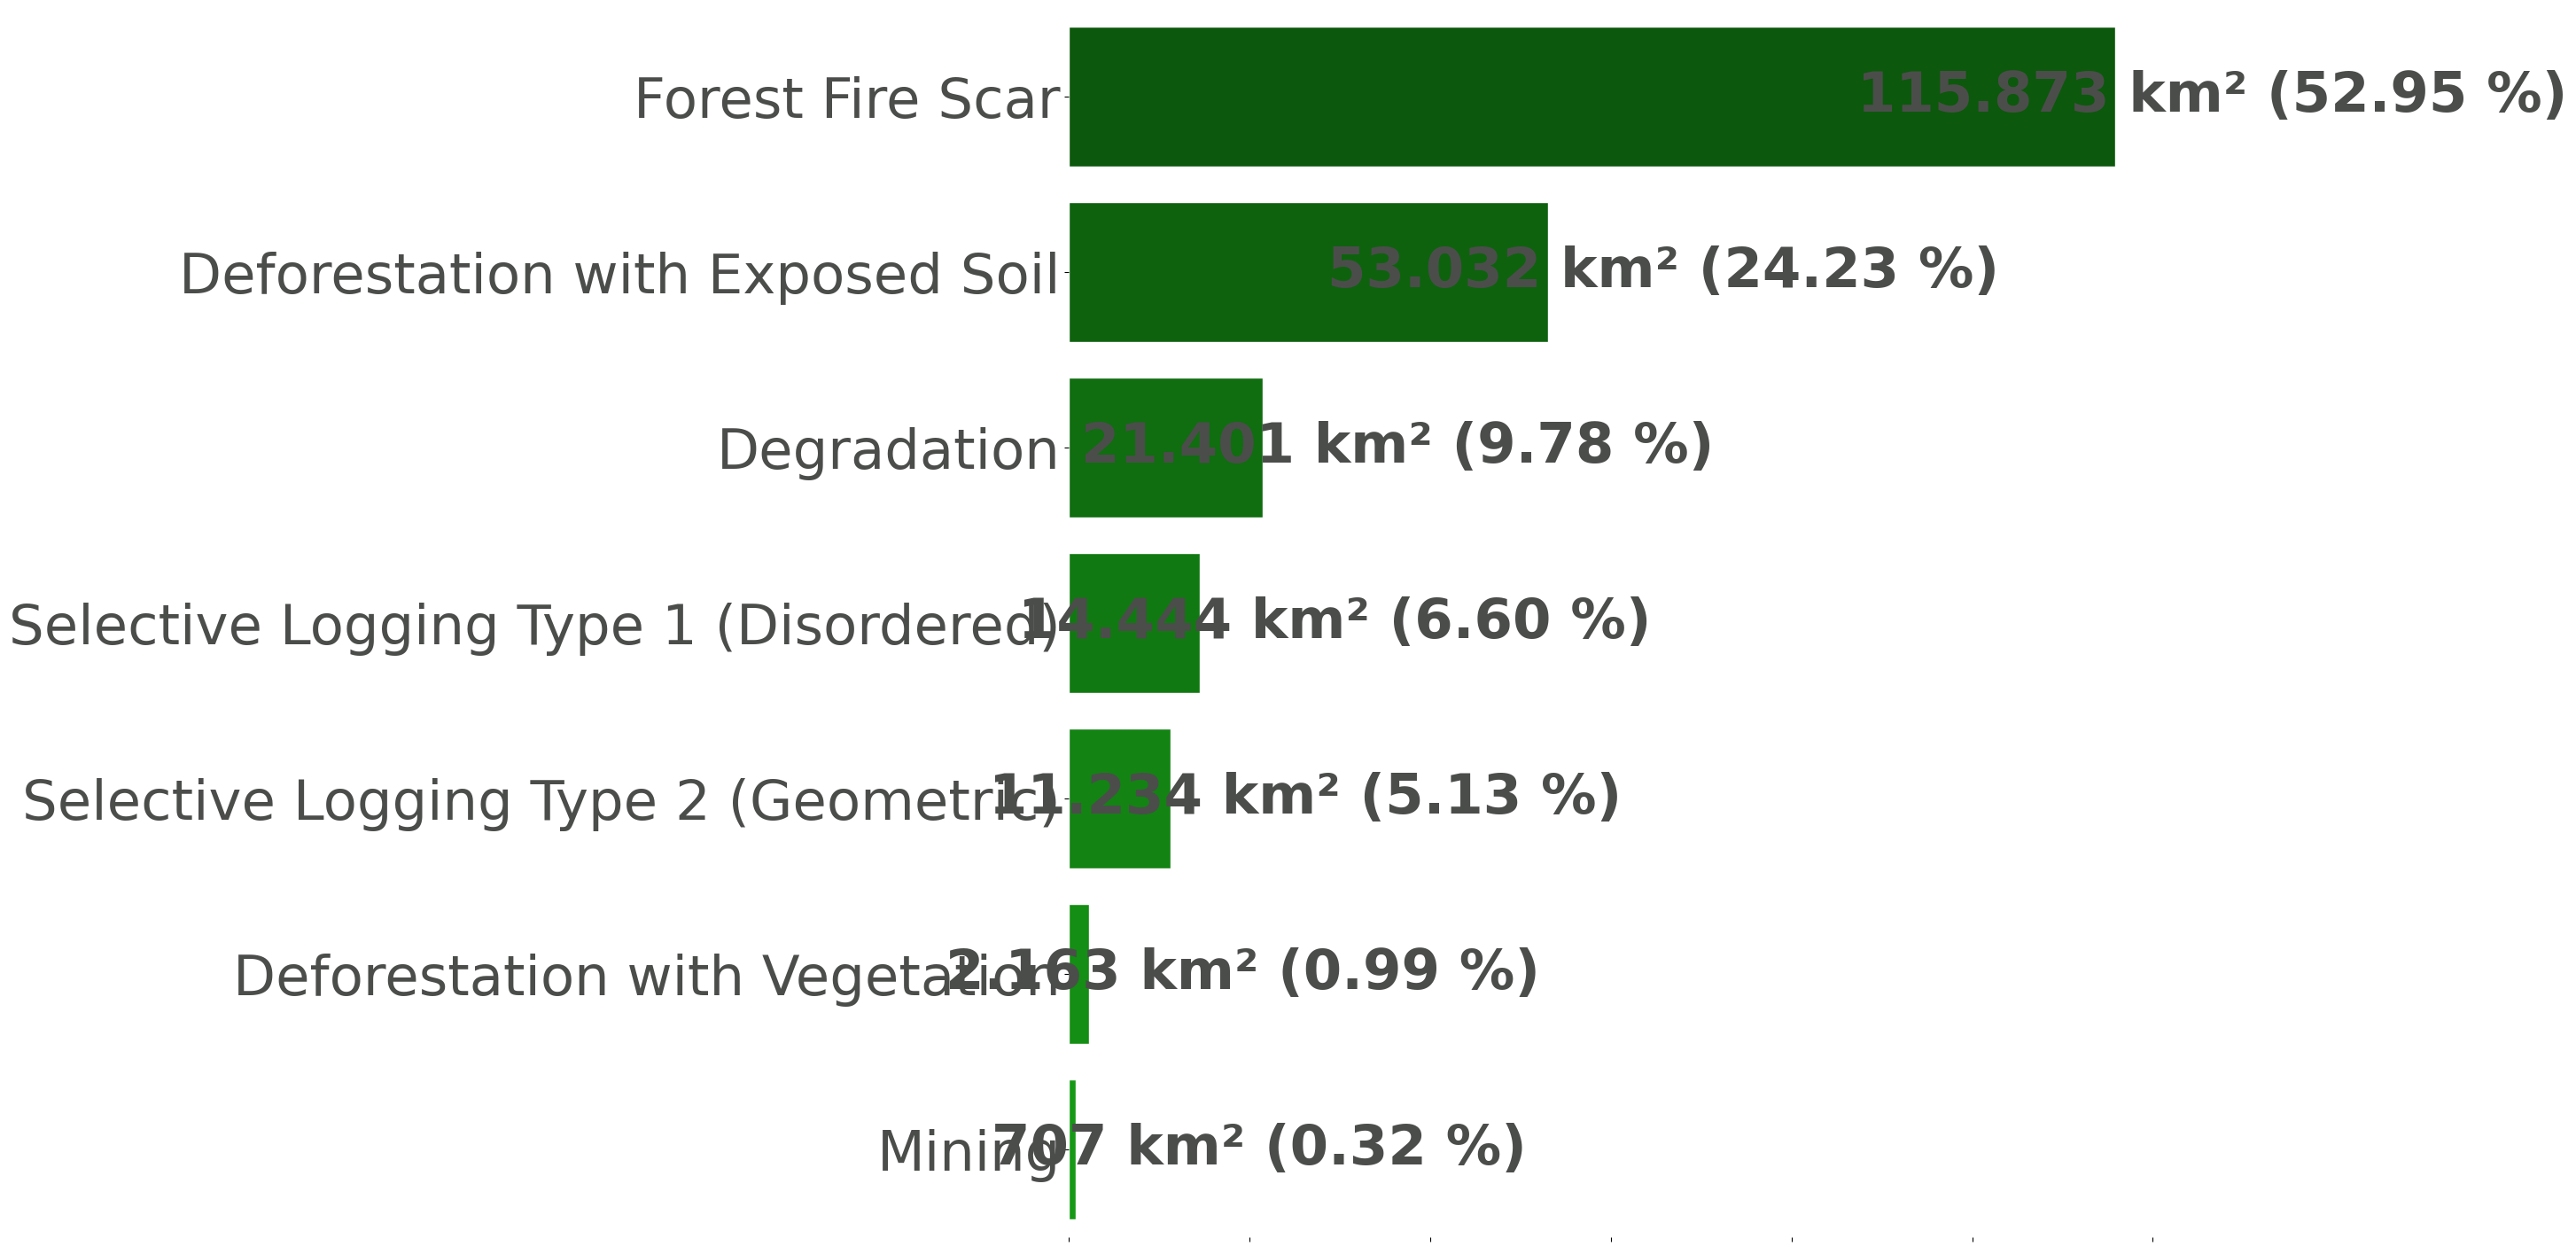

In [9]:
dict_classes, texts = get_texts("English")
save_graph("Graph1_EN_new",deter_graph1)

/tmp/ipykernel_215960/1344490381.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df_class, x=df_class.AREAMUNKM, y = df_class.DESC, palette=palette_gen())
/tmp/ipykernel_215960/1344490381.py:9: UserWarning: The palette list has more values (9) than needed (7), which may not be intended.
  ax = sns.barplot(data=df_class, x=df_class.AREAMUNKM, y = df_class.DESC, palette=palette_gen())


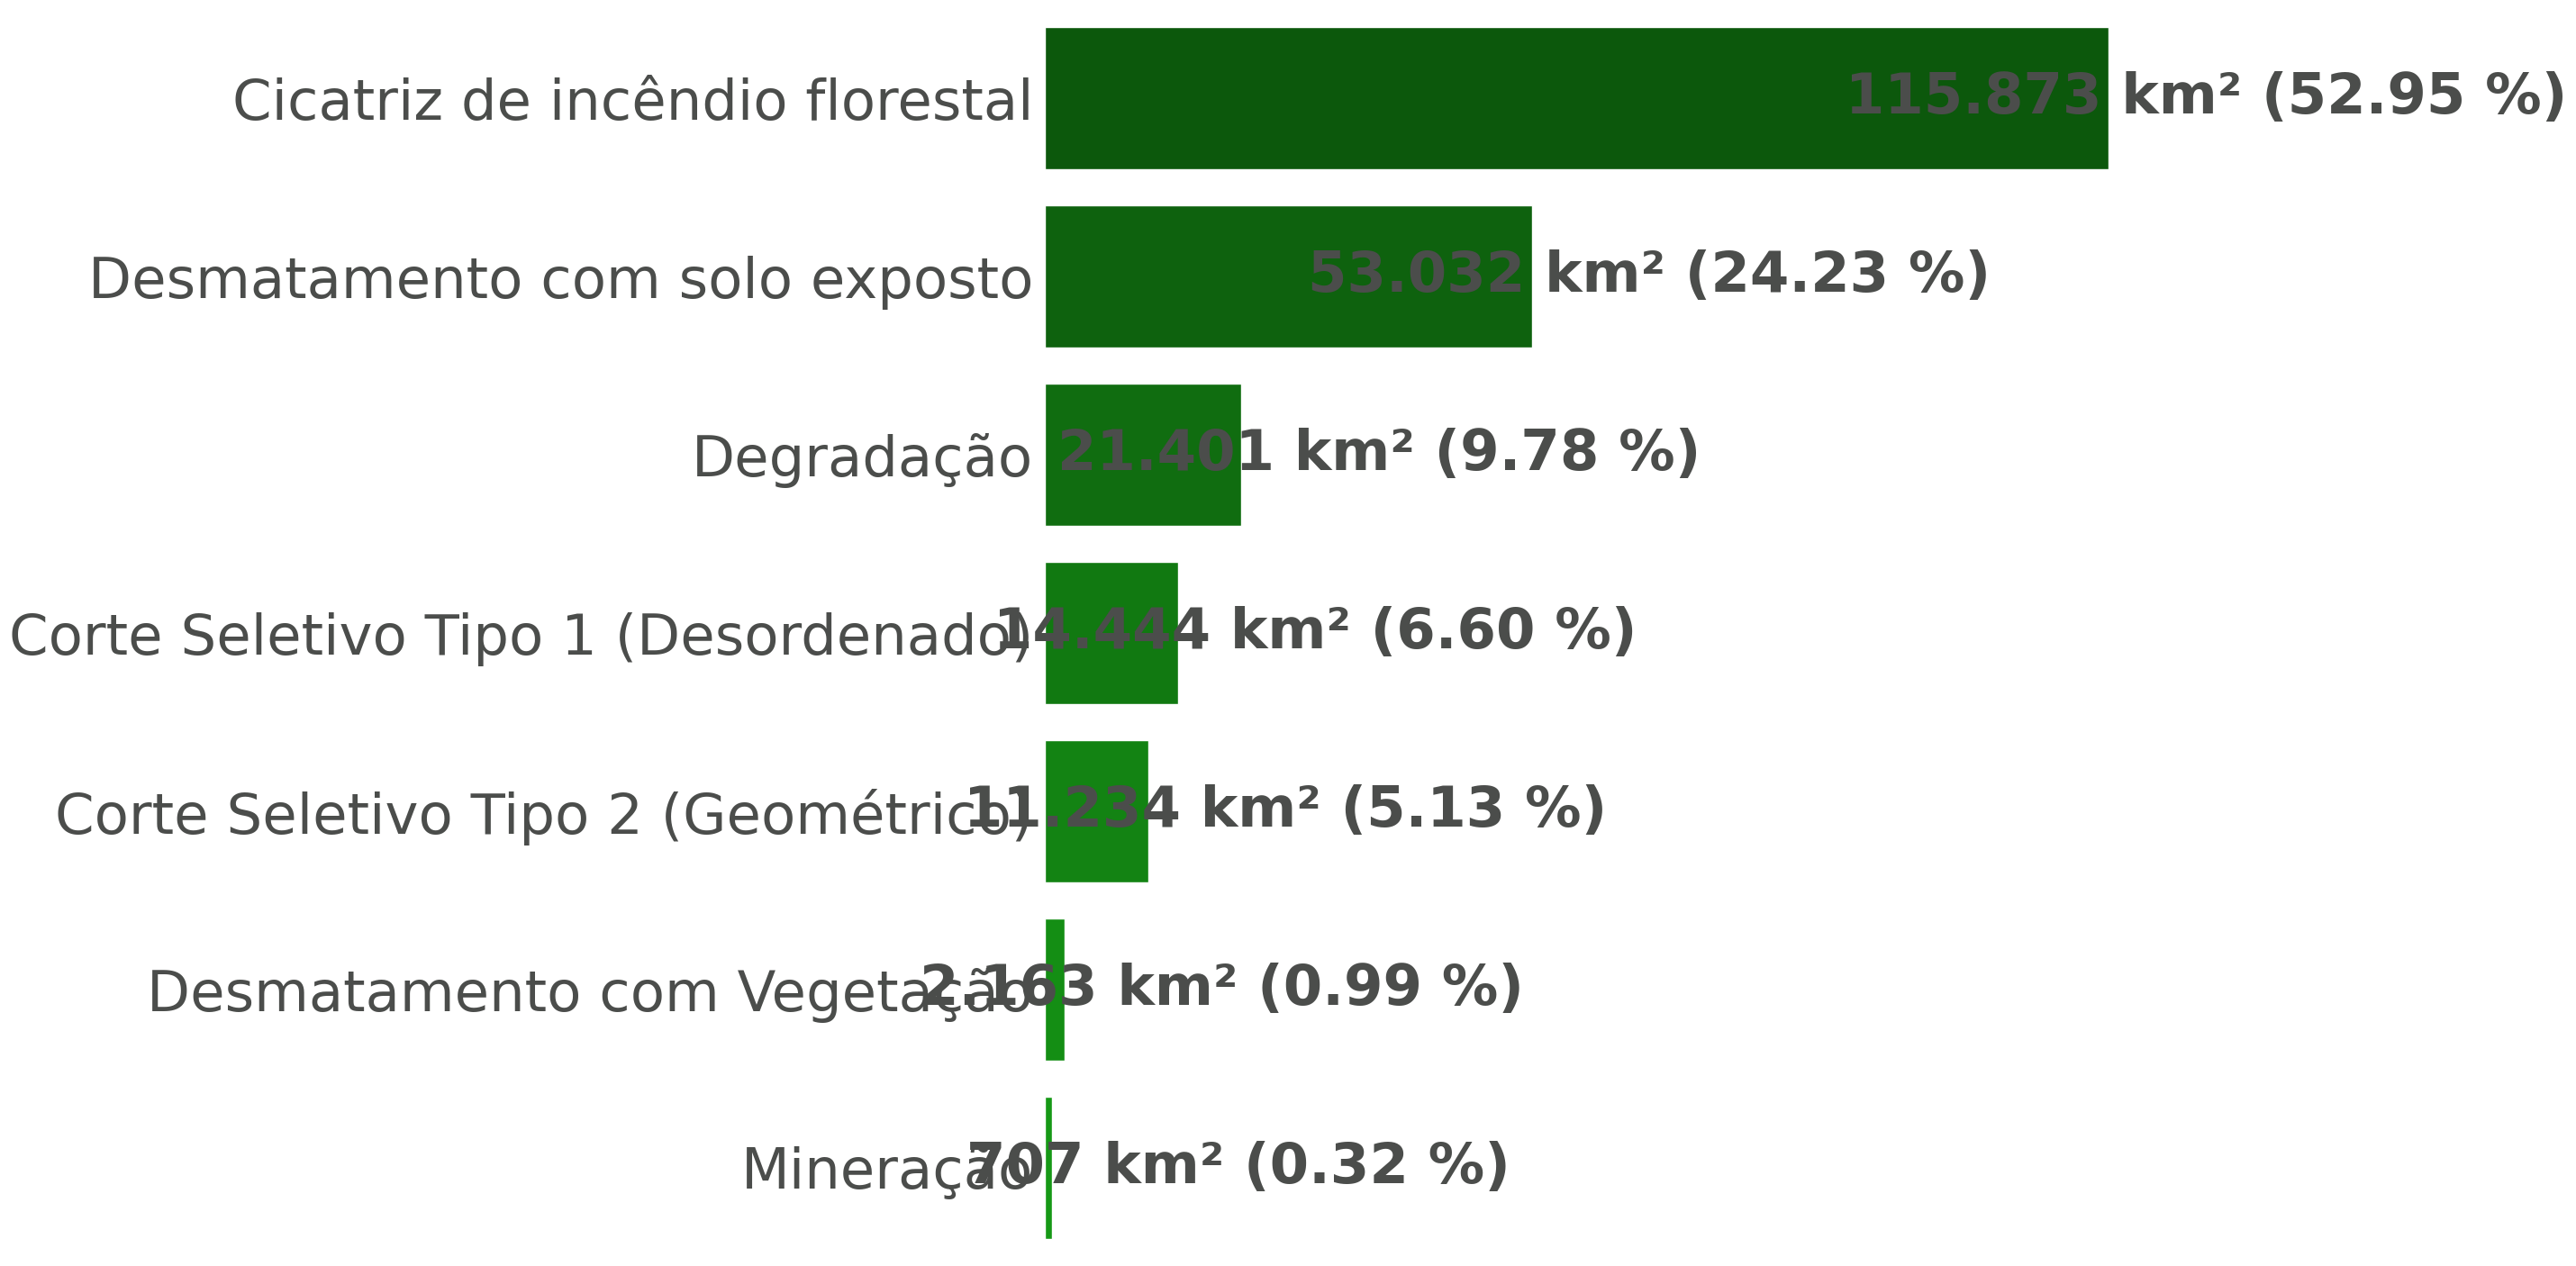

In [10]:
dict_classes, texts = get_texts("Portuguese")
save_graph("Graph1_PT_new",deter_graph1)

### Graph 2:

In [10]:
def deter_graph2():
    class_count = pd.DataFrame(df_deter['CLASSNAME'].value_counts())
    class_count['DESC'] = class_count.index.map(dict_classes)
    class_count.reset_index()

    fig, ax = plt.subplots(figsize=(16,18))
    sns.set_theme(style="white")
    ax = sns.barplot(data=class_count, x=class_count['count'], y = class_count['DESC'], palette=palette_gen())
    #ax.set_title(texts['title_deter_graph2'], fontsize=65, color=gray, fontweight='bold');
    #fig.suptitle(texts['title_deter_graph2'], fontsize=65, color=gray, fontweight='bold')
    ax.set_xlabel('');
    ax.set_ylabel('');
    ax.set_xticklabels([]);
    ax.yaxis.set_tick_params(labelsize=45, labelcolor = gray)
    sns.despine(left = True, bottom = True)
    
    for i, valor in enumerate(class_count['count']):
        p = (valor * 100) / class_count['count'].sum()
        qtd = f'{valor:,.0f} ({p:,.2f} %)'.replace(',','.')  
        #offset = 1e3  # offset de 1.000
        ax.text(valor + 105000, i, qtd, color= gray, fontsize=45, fontweight='bold', ha='right', va='center')

    return fig, ax

C:\Users\shail\AppData\Local\Temp\ipykernel_39296\1504122634.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=class_count, x=class_count['count'], y = class_count['DESC'], palette=palette_gen())
C:\Users\shail\AppData\Local\Temp\ipykernel_39296\1504122634.py:8: UserWarning: The palette list has more values (9) than needed (7), which may not be intended.
  ax = sns.barplot(data=class_count, x=class_count['count'], y = class_count['DESC'], palette=palette_gen())


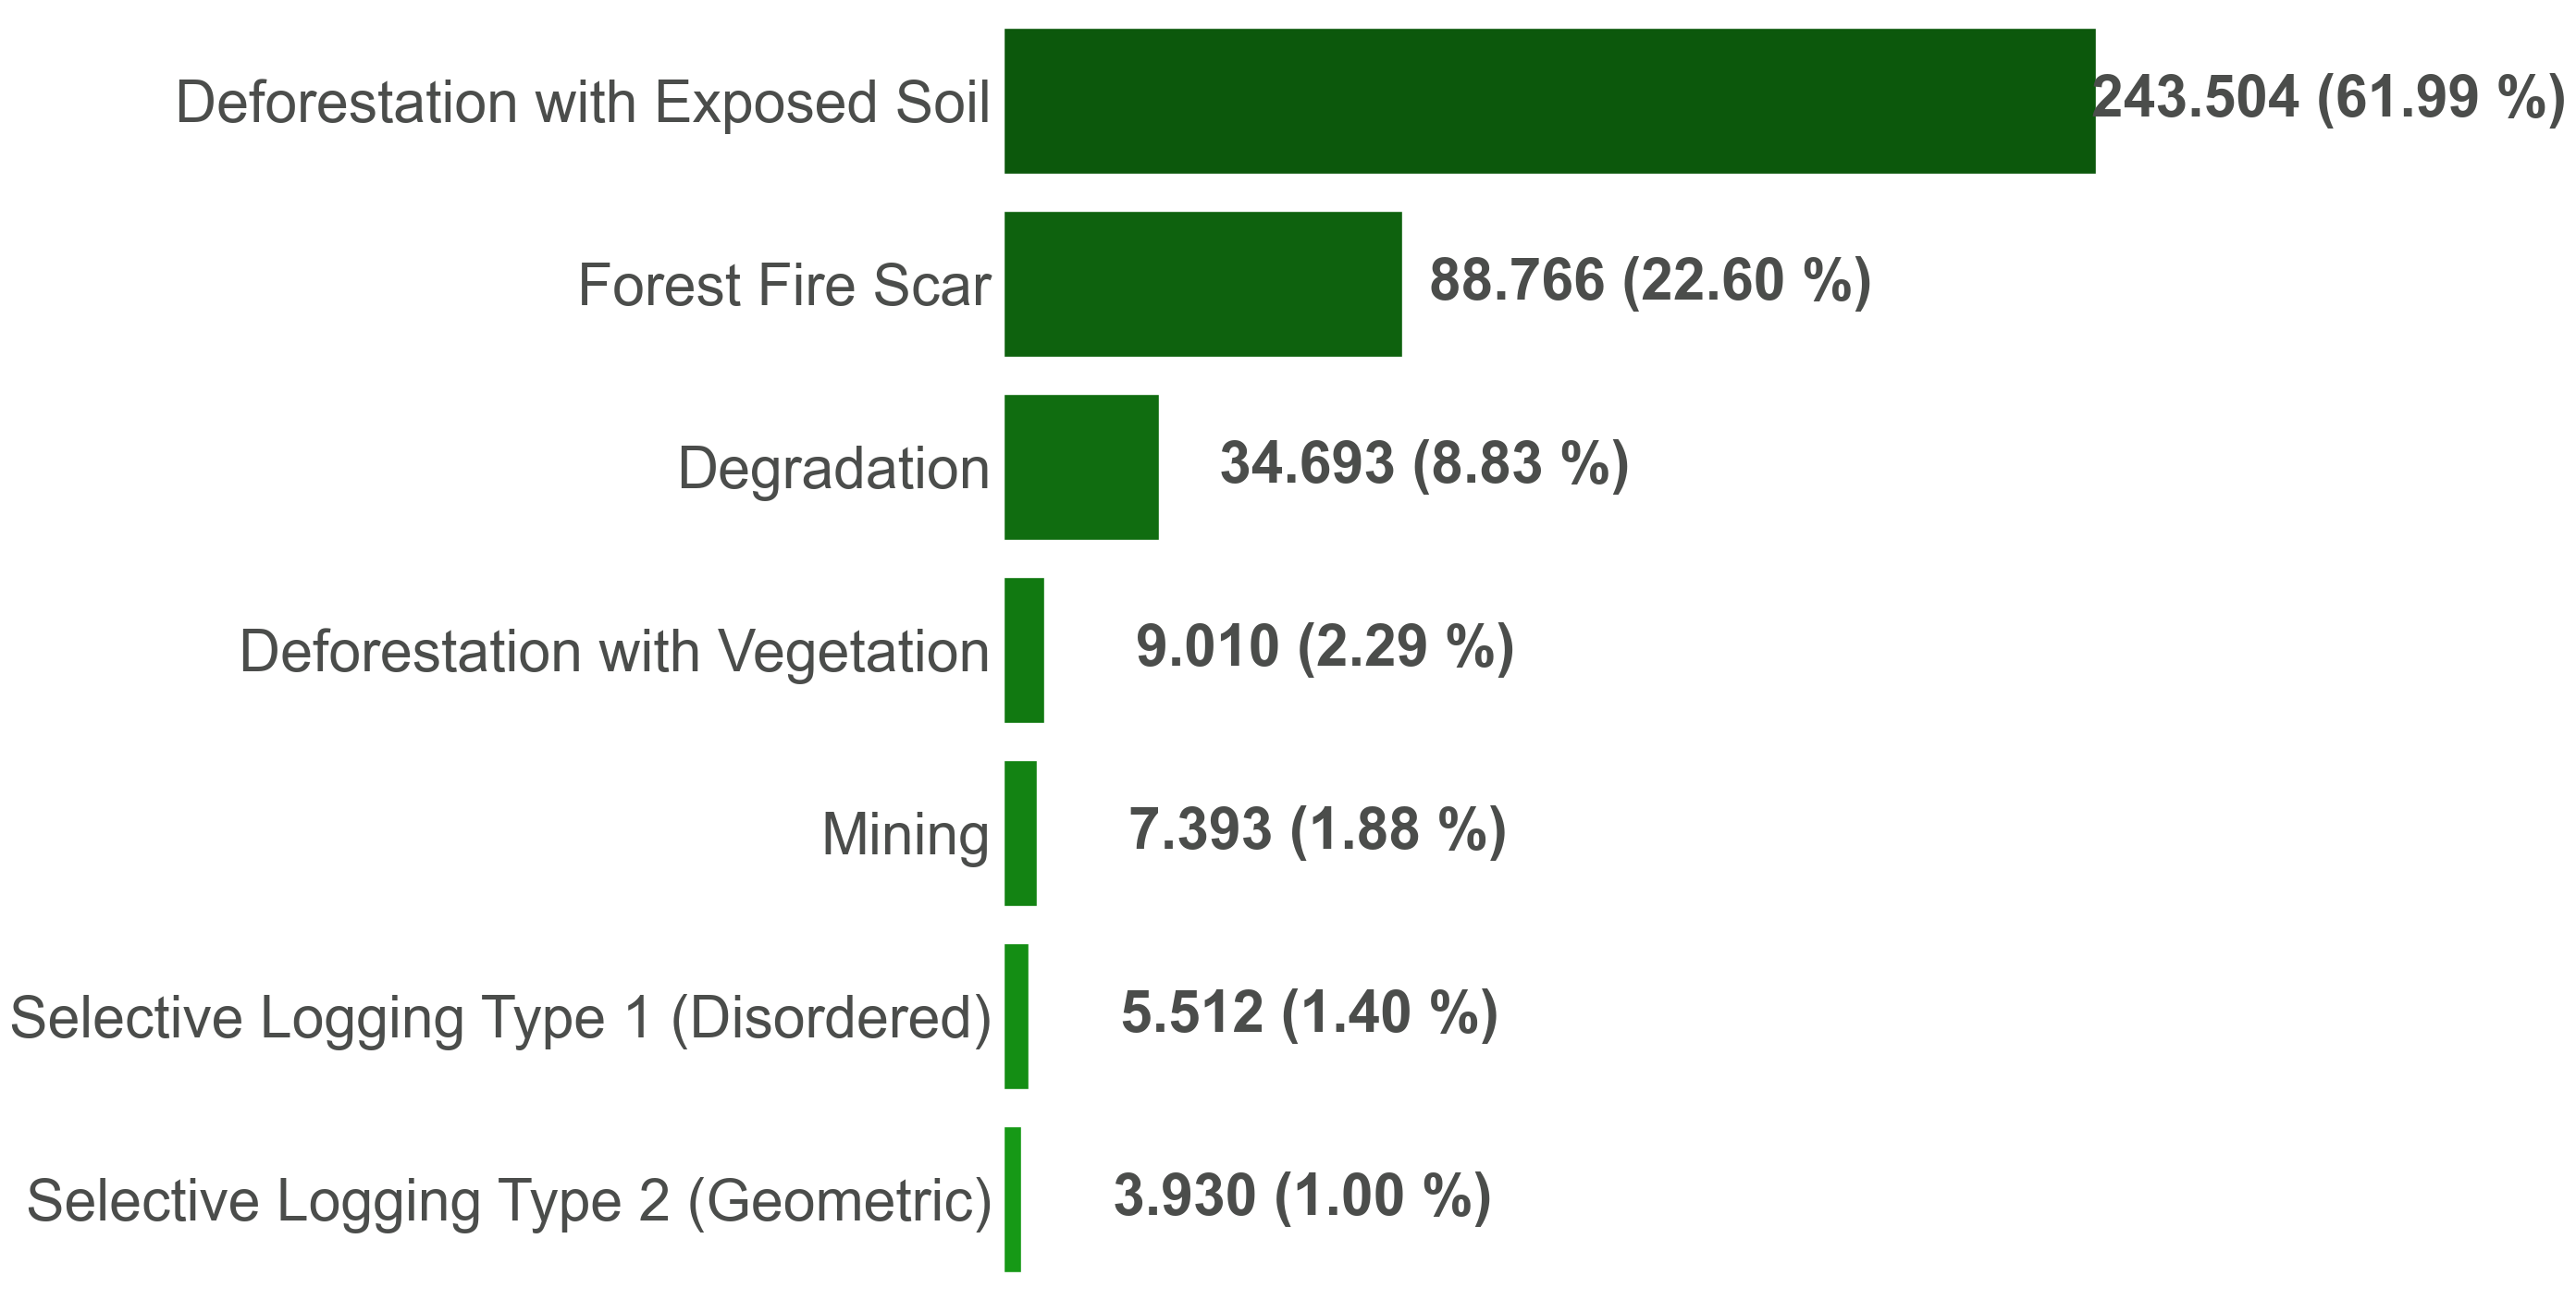

In [11]:
dict_classes, texts = get_texts("English")
save_graph("Graph2_EN_new",deter_graph2)

C:\Users\shail\AppData\Local\Temp\ipykernel_39296\1504122634.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=class_count, x=class_count['count'], y = class_count['DESC'], palette=palette_gen())
C:\Users\shail\AppData\Local\Temp\ipykernel_39296\1504122634.py:8: UserWarning: The palette list has more values (9) than needed (7), which may not be intended.
  ax = sns.barplot(data=class_count, x=class_count['count'], y = class_count['DESC'], palette=palette_gen())


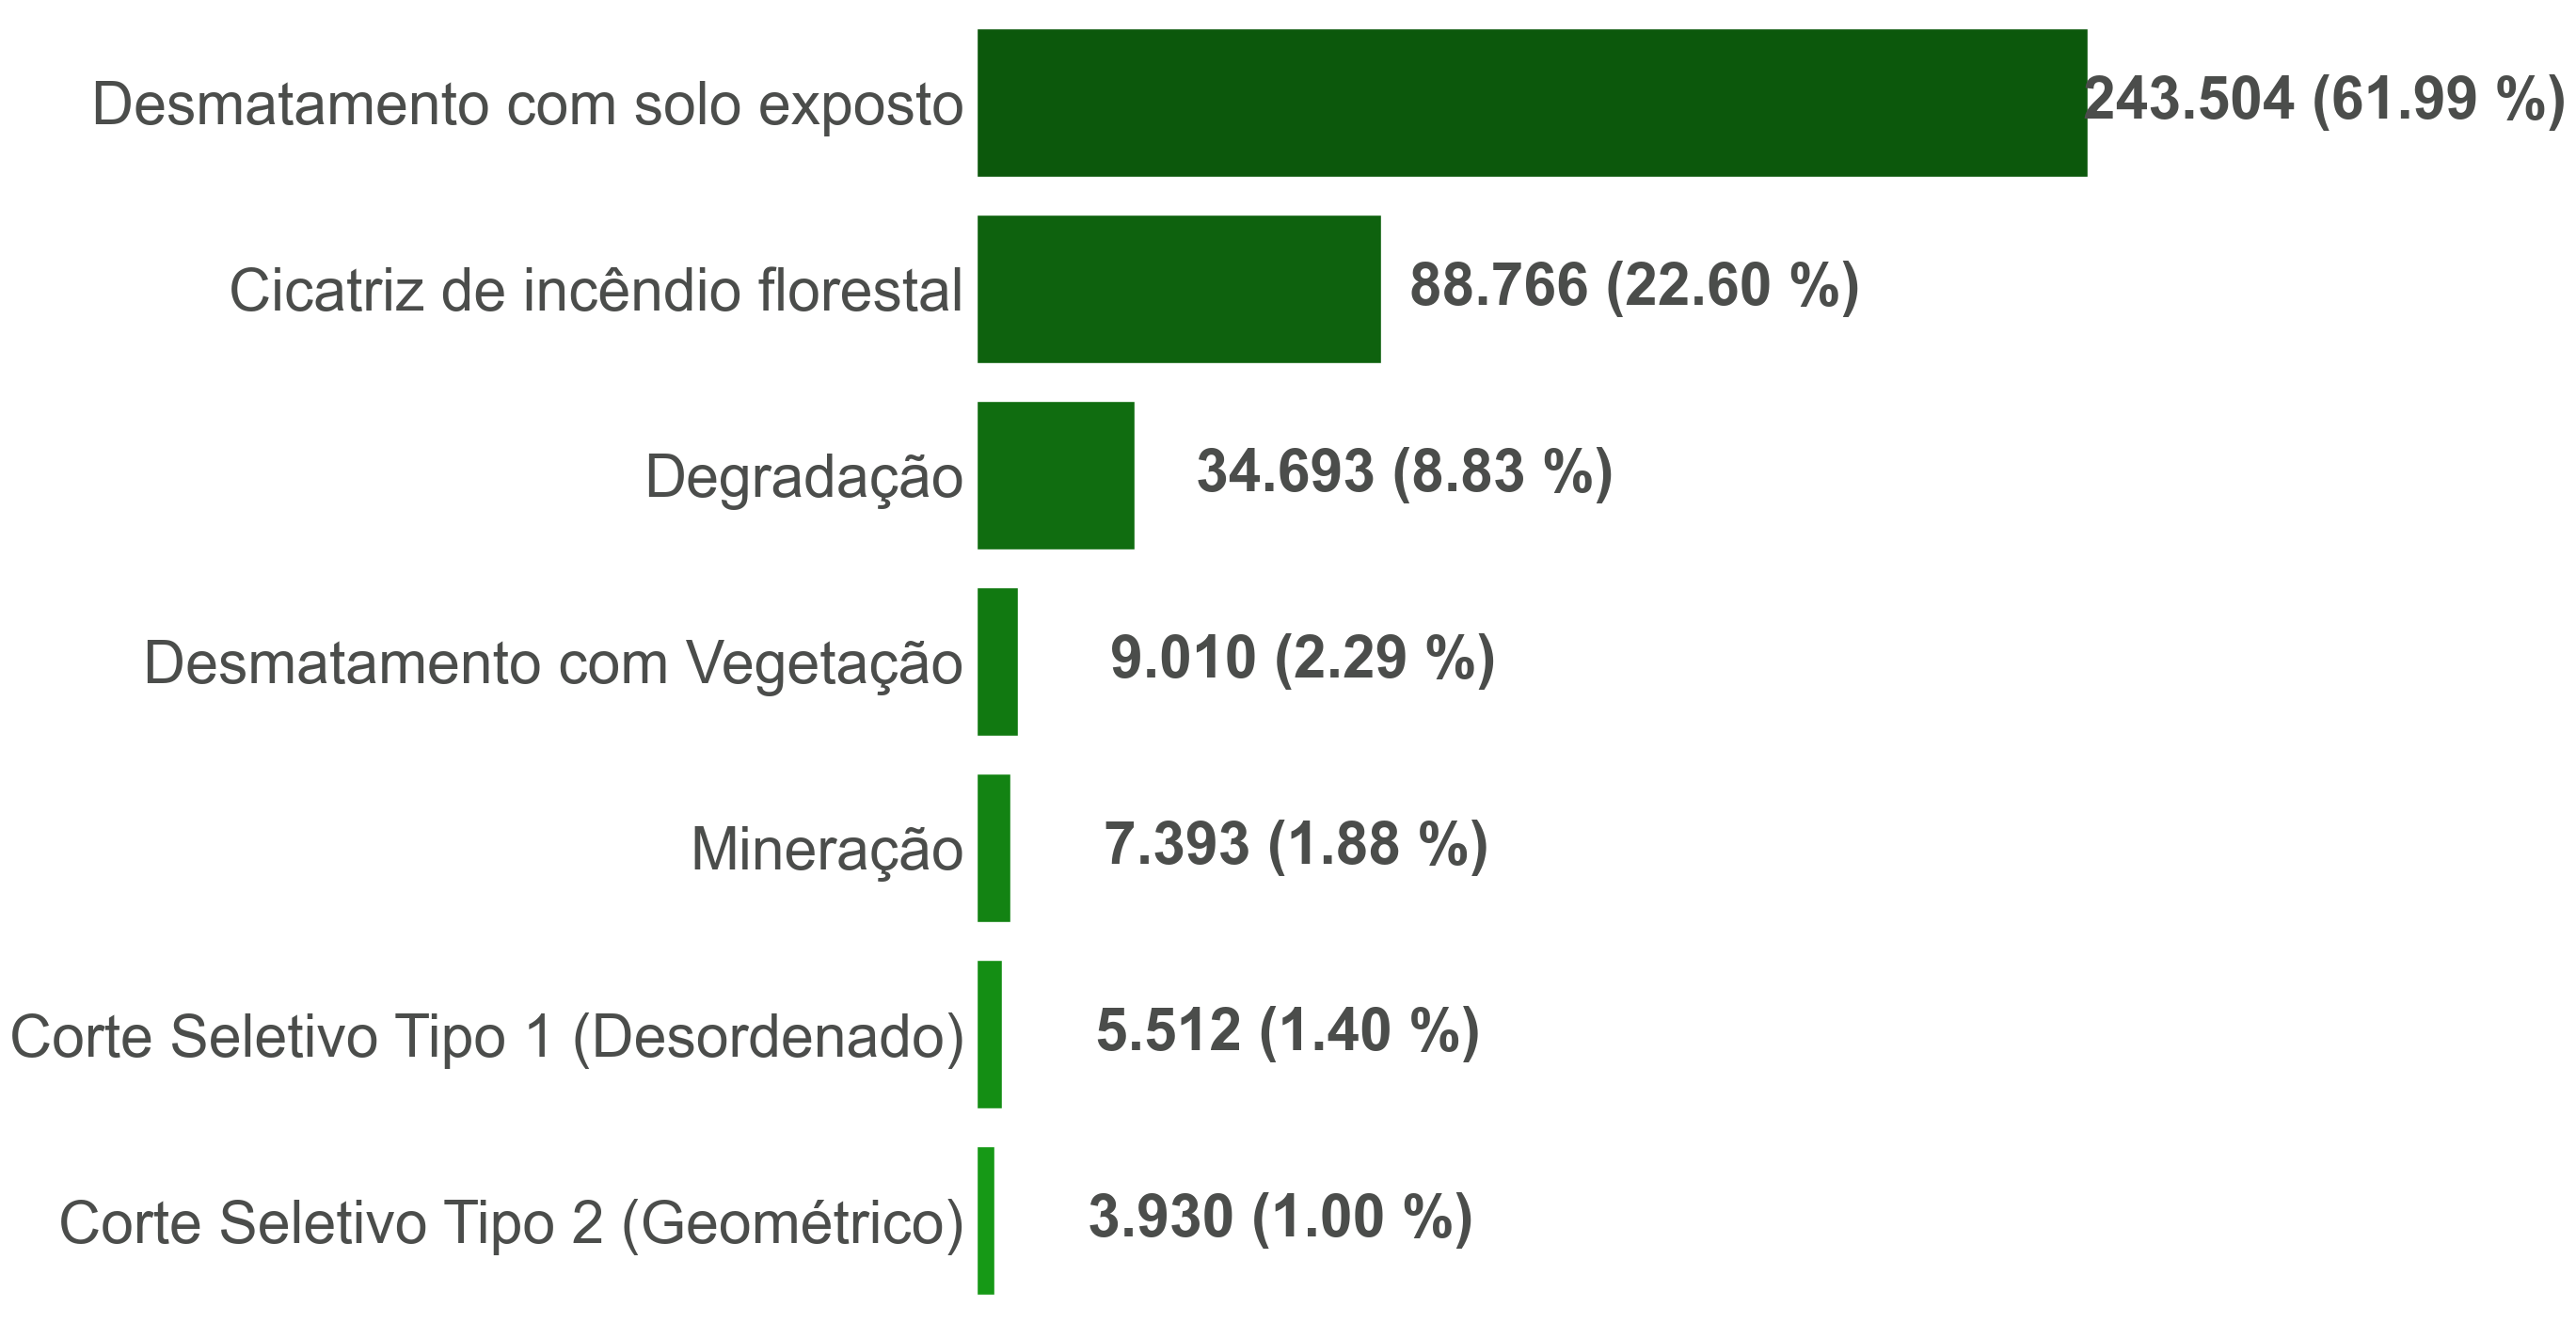

In [12]:
dict_classes, texts = get_texts("Portuguese")
save_graph("Graph2_PT_new",deter_graph2)

### Graph 3:

In [11]:
def deter_graph3():
    gb_uf = df_deter.groupby('UF')['AREAMUNKM'].sum().sort_values(ascending=False)
    gb_uf = pd.DataFrame(gb_uf)

    gb_uf['NOME_ESTADO'] = gb_uf.index.map(estados)
    gb_uf['NOME E SIGLA'] = gb_uf['NOME_ESTADO'] + ' (' + gb_uf.index + ')   '
    
    
    #print(gb_uf)
    
    fig, ax = plt.subplots(figsize=(12,5))
    sns.set_theme(style="white")
    ax = sns.barplot(data=gb_uf, x=gb_uf.AREAMUNKM, y = gb_uf['NOME E SIGLA'], palette=palette_gen())
    #fig.suptitle(texts['title_deter_graph3'], fontsize=25, color=gray, fontweight='bold')
    #ax.set_title(texts['title_deter_graph3'], fontsize=50, color=gray, fontweight='bold');
    ax.set_xlabel('');
    ax.set_ylabel('');
    ax.set_xticklabels([]);
    ax.tick_params(axis='both', which='both', length=0)
    ax.yaxis.set_tick_params(labelsize=12, labelcolor = gray)
    sns.despine(left = True, bottom = True)

    for i, valor in enumerate(gb_uf.AREAMUNKM):
        p = (valor * 100) / gb_uf['AREAMUNKM'].sum()
        qtd = f'{valor:,.0f} km² ({p:,.2f} %)'.replace(',','.')  
        offset = 12e3  # offset de 1.000


        if valor>2000:
            offset = 13e3
        if valor>10000:
            offset = 138e2
        if valor>50000:
            offset = 145e2
        ax.text(valor + offset, i, qtd, color= gray, fontsize=12, fontweight='bold', ha='right', va='center')

    return fig, ax

C:\Users\shail\AppData\Local\Temp\ipykernel_39296\1431541720.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=gb_uf, x=gb_uf.AREAMUNKM, y = gb_uf['NOME E SIGLA'], palette=palette_gen())


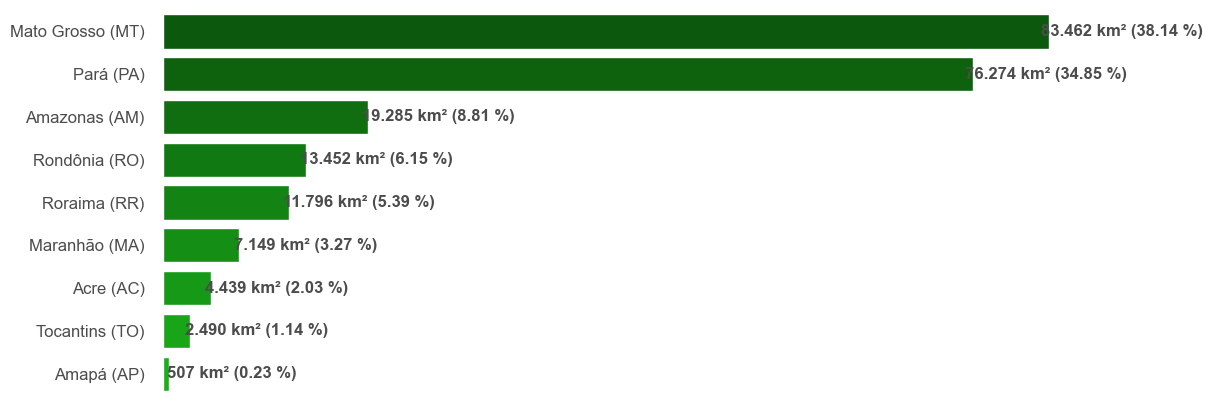

In [14]:
dict_classes, texts = get_texts("English")
save_graph("Graph3_EN_new",deter_graph3)

C:\Users\shail\AppData\Local\Temp\ipykernel_39296\1431541720.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=gb_uf, x=gb_uf.AREAMUNKM, y = gb_uf['NOME E SIGLA'], palette=palette_gen())


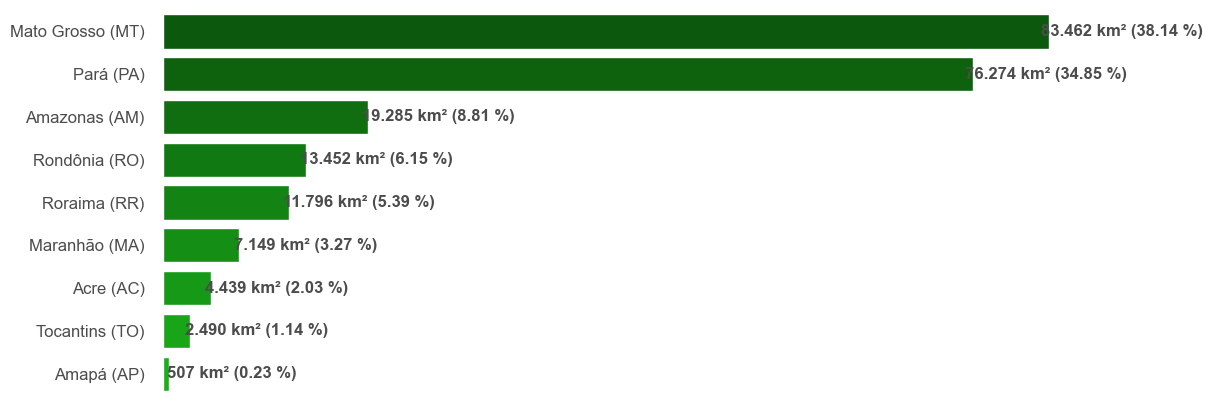

In [15]:
dict_classes, texts = get_texts("Portuguese")
save_graph("Graph3_PT_new",deter_graph3)

### Graph 4:

In [16]:
def deter_graph4(qtd = 25,fs=(8,7)):
    sum_areamunkm = df_deter.groupby('MUNICIPALI')['AREAMUNKM'].sum().reset_index()
    info_uf = df_deter.drop_duplicates(subset='MUNICIPALI')[['UF', 'MUNICIPALI']]
    res = pd.merge(sum_areamunkm, info_uf, on='MUNICIPALI', how='left')
    
    top_cities = res.sort_values(by='AREAMUNKM', ascending=False).head(qtd)
    top_cities['MUN/UF'] = top_cities['MUNICIPALI'] + ' (' + top_cities['UF'].str.upper() + ') '

    fig, ax = plt.subplots(figsize=fs)
    sns.set_theme(style="white")
    ax = sns.barplot(data=top_cities, x=top_cities.AREAMUNKM, y = top_cities['MUN/UF'], palette=palette_gen(n_colors=top_cities.shape[0]))
    #ax.set_title(texts['title_deter_graph4'], fontsize=50, color=gray, fontweight='bold');
    #fig.suptitle(texts['title_deter_graph4'], fontsize=23, color=gray, fontweight='bold', horizontalalignment='center',x=0.375,y=0.935)
    ax.set_xlabel('');
    ax.set_ylabel('');
    ax.set_xticklabels([]);
    ax.yaxis.set_tick_params(labelsize=14, labelcolor = gray)
    sns.despine(left = True, bottom = True)
    
    for i, valor in enumerate(top_cities.AREAMUNKM):
        qtd = f'{valor:,.0f} km²'.replace(',','.')  
        #offset = 1e3  # offset de 1.000
        ax.text(valor + 1300, i, qtd, color= gray, fontsize=12, fontweight='bold', ha='right', va='center')
    
    return fig, ax

C:\Users\shail\AppData\Local\Temp\ipykernel_39296\3327133972.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=top_cities, x=top_cities.AREAMUNKM, y = top_cities['MUN/UF'], palette=palette_gen(n_colors=top_cities.shape[0]))


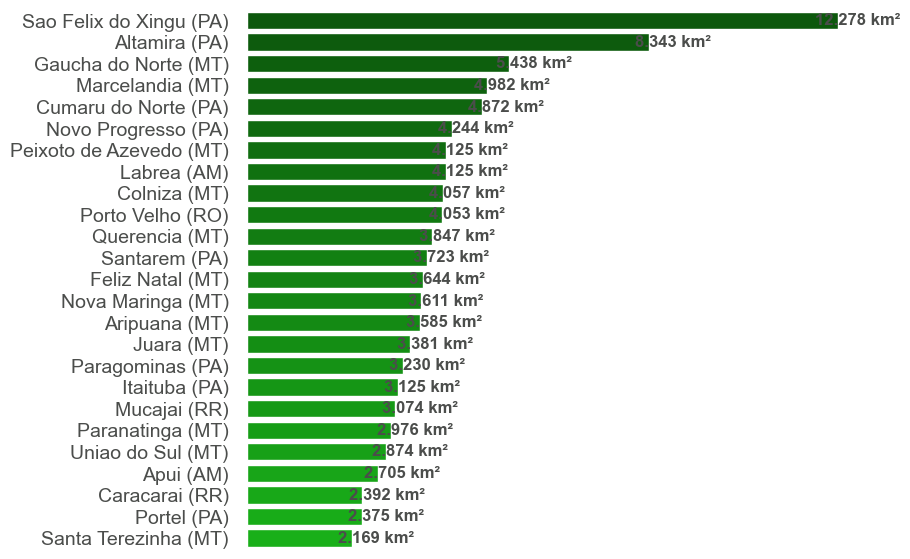

In [17]:
dict_classes, texts = get_texts("English")
save_graph("Graph4_EN_new",deter_graph4)

In [12]:
dict_classes, texts = get_texts("Portuguese")
save_graph("Graph4_PT_new",deter_graph4)

NameError: name 'deter_graph4' is not defined

### Graph 5:

In [19]:
def deter_graph5():
    gb_ym = pd.DataFrame(df_deter.groupby('MES/ANO')['AREAMUNKM'].sum().sort_index()).reset_index()
    
    #Dropando mês incompleto
    most_recent_date = df_deter['VIEW_DATE'].max()
    last_day = pd.to_datetime(f'{most_recent_date.year}-{most_recent_date.month + 1}-01') - pd.Timedelta(days=1)
    
    if most_recent_date < last_day:
        # Se sim, excluir os dados desse mês
        gb_ym = gb_ym[gb_ym['MES/ANO'] < last_day.strftime('%Y-%m')]
    
    #maior valor de impacto mensal no ano
    gb_ym['ANO'] = pd.to_datetime(gb_ym['MES/ANO']).dt.year
    gb_ym['MES'] = pd.to_datetime(gb_ym['MES/ANO']).dt.month
    #max_year = pd.DataFrame(gb_ym.groupby('ANO').max()['AREAMUNKM']).rename(columns={'AREAMUNKM': 'MAX_DMG_YEAR'})
    max_year = gb_ym.groupby('ANO')['AREAMUNKM'].max().rename('MAX_DMG_YEAR').reset_index()
    gb_ym = pd.merge(gb_ym, max_year, on='ANO', how='left')
    
    #Meses que serão plotados
    dots = [True if row['AREAMUNKM'] == row['MAX_DMG_YEAR'] else False for index, row in gb_ym.iterrows()]


    
    fig, ax = plt.subplots(figsize=(27,6))
    gb_ym['MES/ANO'] = pd.to_datetime(gb_ym['MES/ANO'])
    
    ax.plot(gb_ym["MES/ANO"].values, gb_ym["AREAMUNKM"].values, lw=3, color = '#00c800', marker ="o", 
              markersize = 10, markerfacecolor = '#006400', markevery = dots)
    #ax.set_title(texts['title_deter_graph5'], fontsize = 45, color = gray, loc='center', pad=17)
    ax.set_frame_on(False)
    ax.xaxis.set_tick_params(labelsize=14, labelcolor = gray)
    ax.grid(which='both', linestyle='--', linewidth=0.5, color='gray', axis='both')
    
    meses = gb_ym['MES/ANO'].dt.month
    first_month = gb_ym["MES/ANO"].min()
    last_month = gb_ym["MES/ANO"].max()
    ticks = pd.date_range(start=first_month, end=last_month, freq='4MS')
    ax.set_xticks(ticks)
    ax.xaxis.set_major_formatter(mdates.DateFormatter(texts['date_format2']))
    ax.set_xlim(first_month - DateOffset(months=1), last_month)
    
    for i in range(0, gb_ym.shape[0]):
    
        if gb_ym['AREAMUNKM'][i] == gb_ym['MAX_DMG_YEAR'][i]:
            ax.annotate(f"{gb_ym['AREAMUNKM'][i]:.2f} km²\n  ({gb_ym['MES/ANO'][i].strftime(texts['date_format2'])})", 
                        xy=(gb_ym["MES/ANO"][i], gb_ym['AREAMUNKM'][i]), 
                        xytext=(-35, 15), textcoords='offset points',
                        color='#006400', weight="bold", fontsize=16,
                        )#arrowprops=dict(arrowstyle="->", color='#006400')
    
    plt.xticks(rotation=0);
    
    return fig, ax

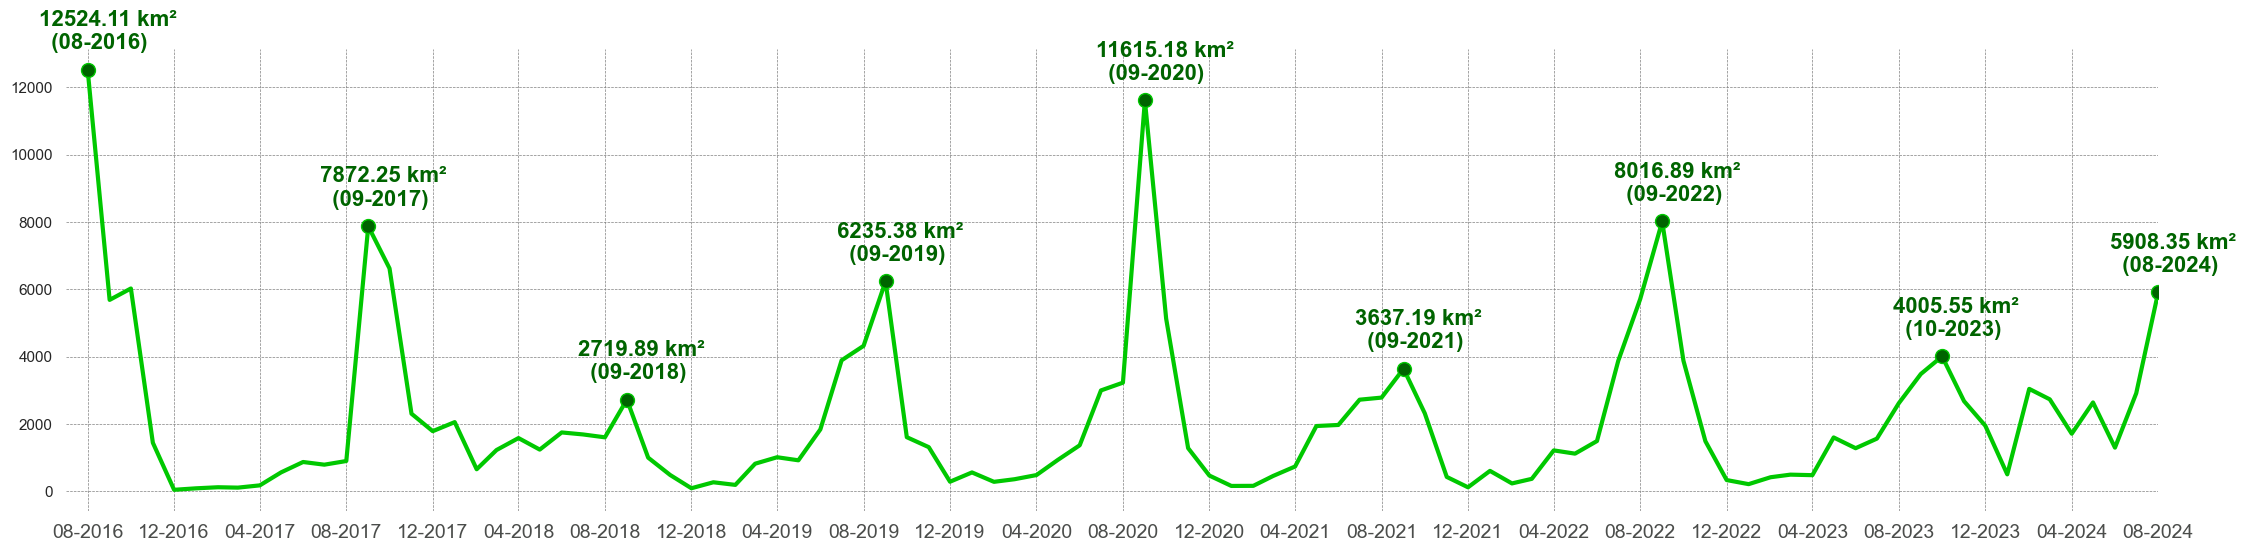

In [20]:
dict_classes, texts = get_texts("English")
save_graph("Graph5_EN_new",deter_graph5)

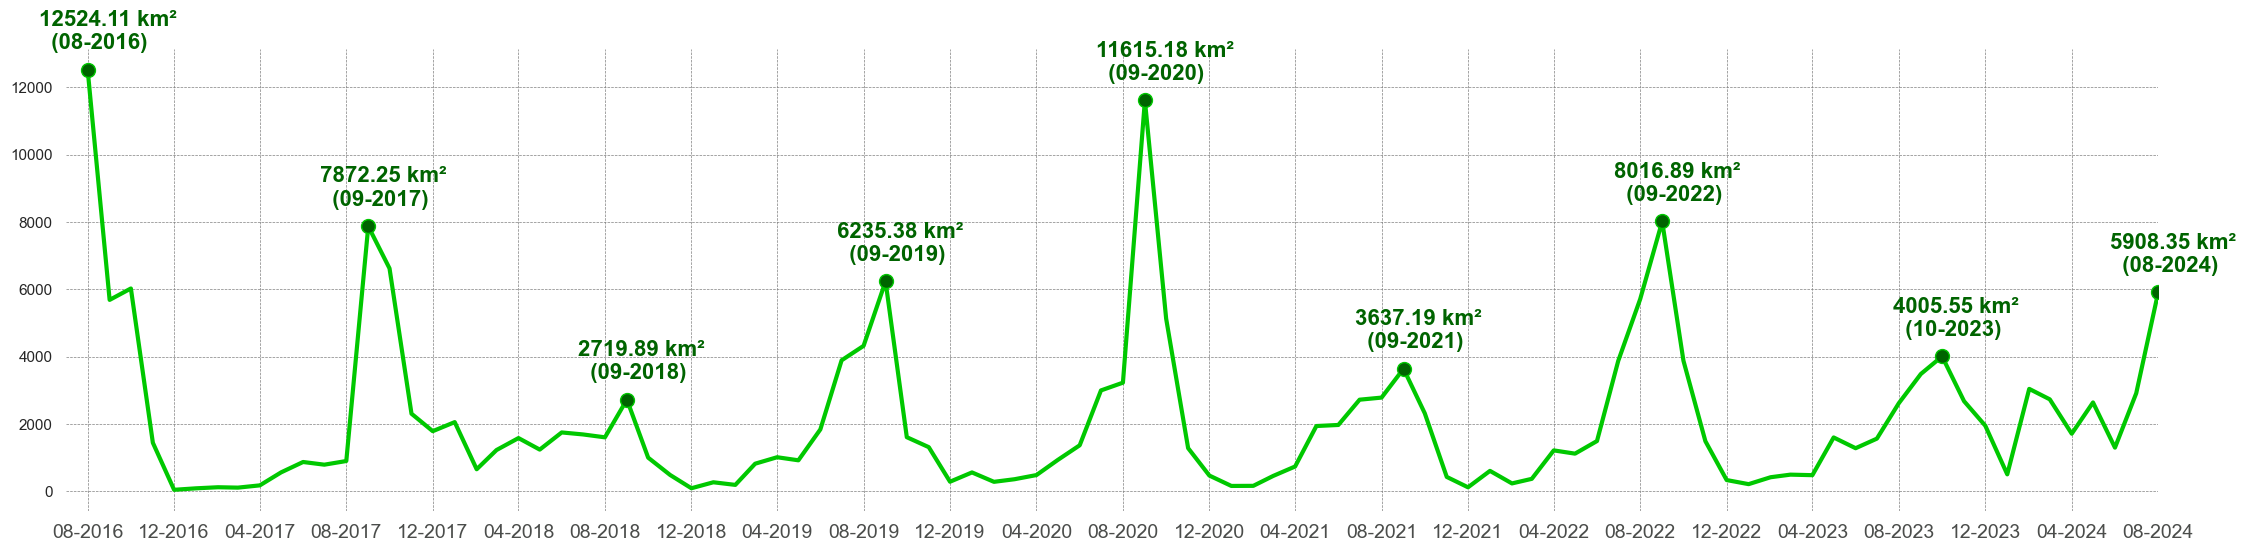

In [21]:
dict_classes, texts = get_texts("Portuguese")
save_graph("Graph5_PT_new",deter_graph5)

### Graph 6:

In [22]:
def deter_graph6():
    complete_years = df_deter.groupby('ANO')['MES'].nunique().reset_index()
    complete_years = complete_years[complete_years['MES'] == 12]['ANO']

    y1 = complete_years.min()
    y2 = complete_years.max()
    
    df_month = df_deter[df_deter['ANO'].isin(complete_years)]['AREAMUNKM'].groupby(df_deter['MES']).sum().sort_index()
    df_month = pd.DataFrame(df_month)

    fig, ax = plt.subplots(figsize=(17,5))
    
    norm = plt.Normalize(df_month.values.min()-50000, df_month.values.max()+20000);
    colors = plt.cm.Greens(norm(df_month));
    
    ax = sns.barplot(data=df_month, x=df_month.index, y=df_month['AREAMUNKM'], palette=colors)
    #ax.set_title(texts['title_deter_graph6'].format(y1,y2), fontsize = 23, color = gray, loc='center', pad=20)
    ax.set_xlabel('')
    ax.set_ylabel('')
    lbs = ast.literal_eval(texts['labels_deter_graph6'])
    plt.xticks(ticks=range(0, 12), labels=lbs);
    ax.set_frame_on(False)
    plt.gca().set_yticks([])
    
    for i, area in enumerate(df_month['AREAMUNKM']):
        qtd = f'{area:,.0f} km²'.replace(',', '.')
        offset = 750
        ax.text(i, area + offset, qtd, color= gray, fontsize=12, ha='center', va='center')

    return fig, ax, y1, y2

In [23]:
def save_graph_wperiod(file_name,graph_func):
    fig, ax, y1, y2 = graph_func()
    fig.savefig(f"../Visualizations/DETER/Graphs/{file_name}.png", bbox_inches='tight', pad_inches=0.1)

    period = f"{y1};{y2}"
    with open(f"../Visualizations/DETER/Graphs/{file_name}_period.txt", "w") as text_file:
        text_file.write(period)

C:\Users\shail\AppData\Local\Temp\ipykernel_39296\3815743221.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df_month, x=df_month.index, y=df_month['AREAMUNKM'], palette=colors)
C:\Users\shail\AppData\Local\Temp\ipykernel_39296\3815743221.py:16: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  ax = sns.barplot(data=df_month, x=df_month.index, y=df_month['AREAMUNKM'], palette=colors)


ValueError: RGBA sequence should have length 3 or 4

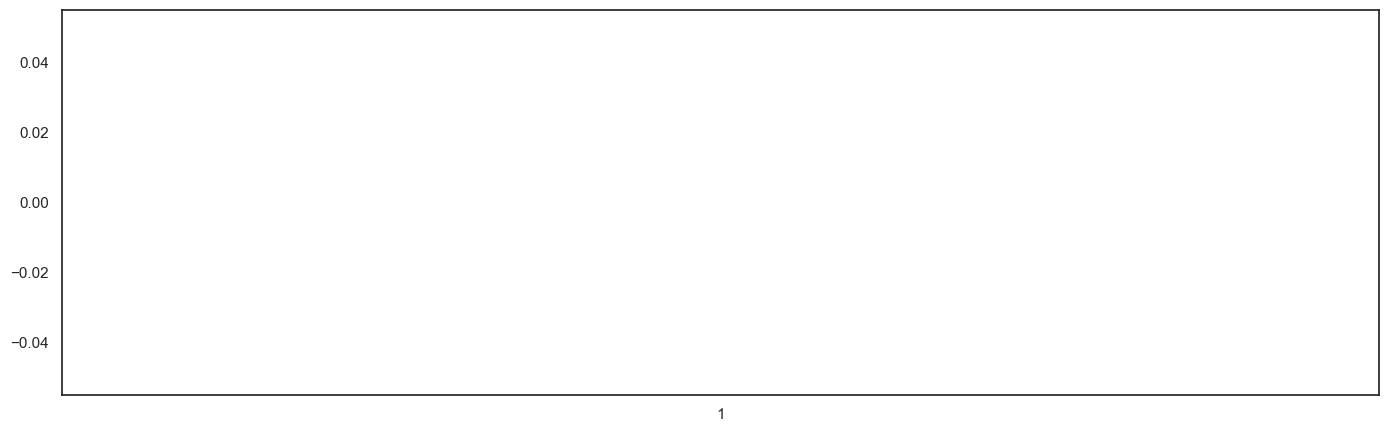

In [24]:
dict_classes, texts = get_texts("English")
save_graph_wperiod("Graph6_EN_new",deter_graph6)

C:\Users\shail\AppData\Local\Temp\ipykernel_39296\3815743221.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df_month, x=df_month.index, y=df_month['AREAMUNKM'], palette=colors)
C:\Users\shail\AppData\Local\Temp\ipykernel_39296\3815743221.py:16: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  ax = sns.barplot(data=df_month, x=df_month.index, y=df_month['AREAMUNKM'], palette=colors)


ValueError: RGBA sequence should have length 3 or 4

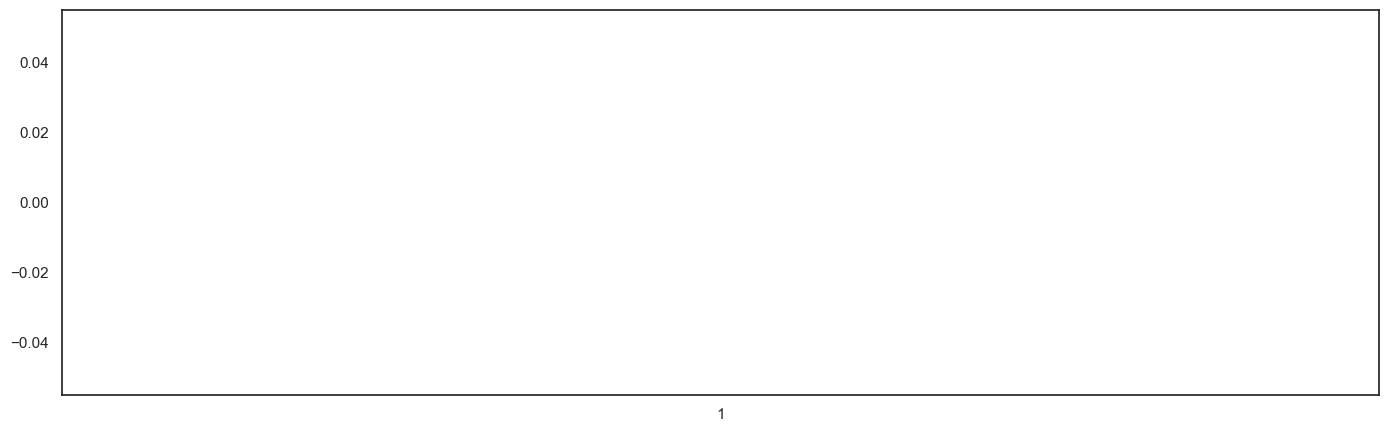

In [25]:
dict_classes, texts = get_texts("Portuguese")
save_graph_wperiod("Graph6_PT_new",deter_graph6)

### Graph 7:

In [25]:
def deter_graph7():
    complete_years = df_deter.groupby('ANO')['MES'].nunique().reset_index()
    complete_years = complete_years[complete_years['MES'] == 12]['ANO']
    # df_month = df_deter[df_deter['ANO'].isin(complete_years)]['AREAMUNKM'].groupby(df_deter['MES']).sum().sort_index()
    # df_month = pd.DataFrame(df_month)
    complete_years_df = df_deter[df_deter['ANO'].isin(complete_years)]
    complete_years_df = pd.DataFrame(complete_years_df['AREAMUNKM'].groupby(df_deter['ANO']).sum().sort_index())
    complete_years_df = complete_years_df.reset_index(drop=False)
    # complete_years_df['VARIACAO_AREA'] = complete_years_df["AREAMUNKM"].diff().fillna(complete_years_df["AREAMUNKM"]).astype("float64")
    # complete_years_df["Medidas"] = ["absolute"] + ["relative"] * 6

    fig, ax = plt.subplots(figsize=(20,7))
    ax = sns.barplot(data=complete_years_df, x=complete_years_df['ANO'], y=complete_years_df['AREAMUNKM'],color='#009600')
    #ax.set_title(texts['title_deter_graph7'], fontsize = 23, color = gray, loc='center', pad=20)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_frame_on(False)
    plt.gca().set_yticks([])
    
    for i, area in enumerate(complete_years_df['AREAMUNKM']):
        qtd = f'{area:,.0f} km²'.replace(',', '.')
        offset = -1500
        
        ax.text(i, area + offset, qtd, color= "#ffffff", fontsize=18, ha='center', va='center', fontweight='bold')
        
        if (i != complete_years_df.shape[0]-1):
            
            dif = complete_years_df['AREAMUNKM'].iloc[i+1] - complete_years_df['AREAMUNKM'].iloc[i]
            
            if dif < 0:
                fcolor = '#00c800'
                ecolor = '#00c800'
                offs = 0.74
                prefix = ''
            else:
                fcolor = '#ff0000'
                ecolor = '#ff0000'
                offs = 0.26
                prefix = '+'
            
            arrow = mpatches.FancyArrowPatch((i + 0.5, complete_years_df['AREAMUNKM'].iloc[i]), (i+0.5, complete_years_df['AREAMUNKM'].iloc[i+1]),
                                         mutation_scale=45, facecolor=fcolor,edgecolor=ecolor)
            ax.add_patch(arrow)
    
            pct = (dif*100) / complete_years_df['AREAMUNKM'].iloc[i]
            textarea = complete_years_df['AREAMUNKM'].iloc[i] +  (dif/2)
            qtd = f'{prefix}{dif:.0f}\n{prefix}{pct:.2f}%'
            ax.text(i + offs, textarea, qtd, color= fcolor, fontsize=15, ha='center', va='center')
    
    return fig, ax

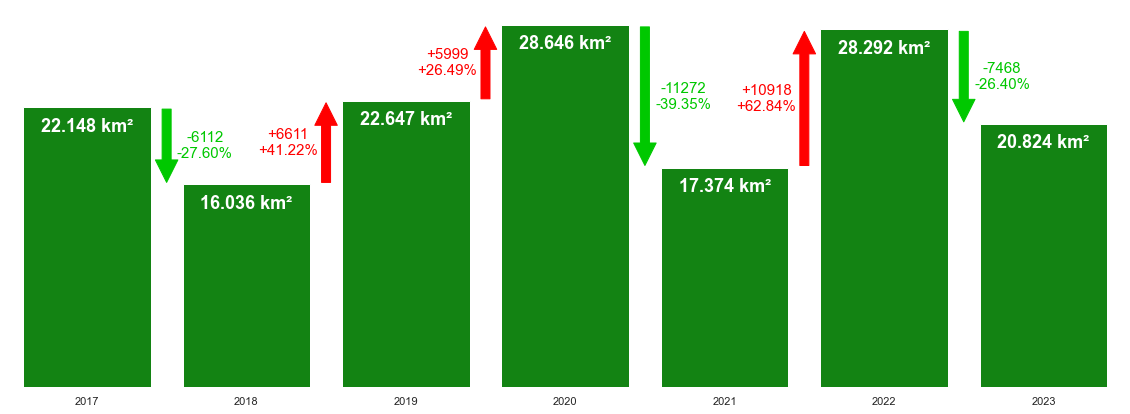

In [26]:
dict_classes, texts = get_texts("English")
save_graph("Graph7_EN",deter_graph7)

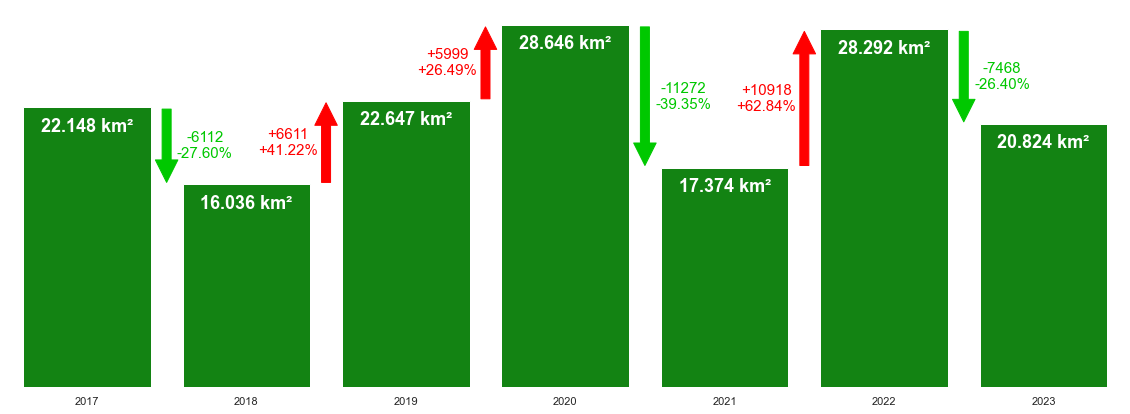

In [27]:
dict_classes, texts = get_texts("Portuguese")
save_graph("Graph7_PT",deter_graph7)

### Graph 8:

In [28]:
def deter_graph8():
    fig, axs = plt.subplots(3, 3, figsize=(20,20), sharey=True)
    #fig.suptitle(texts['graph8_title'], fontsize = 40, color = gray, fontweight='bold')
    plt.subplots_adjust(wspace=0.05, hspace=0.3)  
    sns.set_theme(style="white")
    
    lst_states = list(estados.keys())
    all_classes = sorted(df_deter['CLASSNAME'].unique())
    
    k=0
    
    for i in range(3):
        for j in range(3):
            
            df_state = df_deter[df_deter['UF'] == lst_states[k]]
            df_state_summed = df_state.groupby('CLASSNAME')['AREAMUNKM'].sum().reset_index()
            df_state_complete = pd.DataFrame({'CLASSNAME': all_classes})
            df_state_complete = df_state_complete.merge(df_state_summed, on='CLASSNAME', how='left').fillna(0)
            df_state_complete['DESC'] = df_state_complete['CLASSNAME'].map(dict_classes)
    
            sns.barplot(data=df_state_complete, x='AREAMUNKM', y = 'DESC', palette=palette_gen(), ax=axs[i, j])
            axs[i, j].set_xlabel('');
            axs[i, j].set_ylabel('');
            axs[i, j].yaxis.set_tick_params(labelsize=15, labelcolor = gray)
            sns.despine(left = True, bottom = True)
            axs[i, j].grid(color='gray', linestyle='--', linewidth=0.5)
            axs[i, j].set_title(estados[lst_states[k]] + ' (' + lst_states[k] + ')', fontsize=25, color=gray, fontweight='bold')

            
            k+=1
    return fig, axs

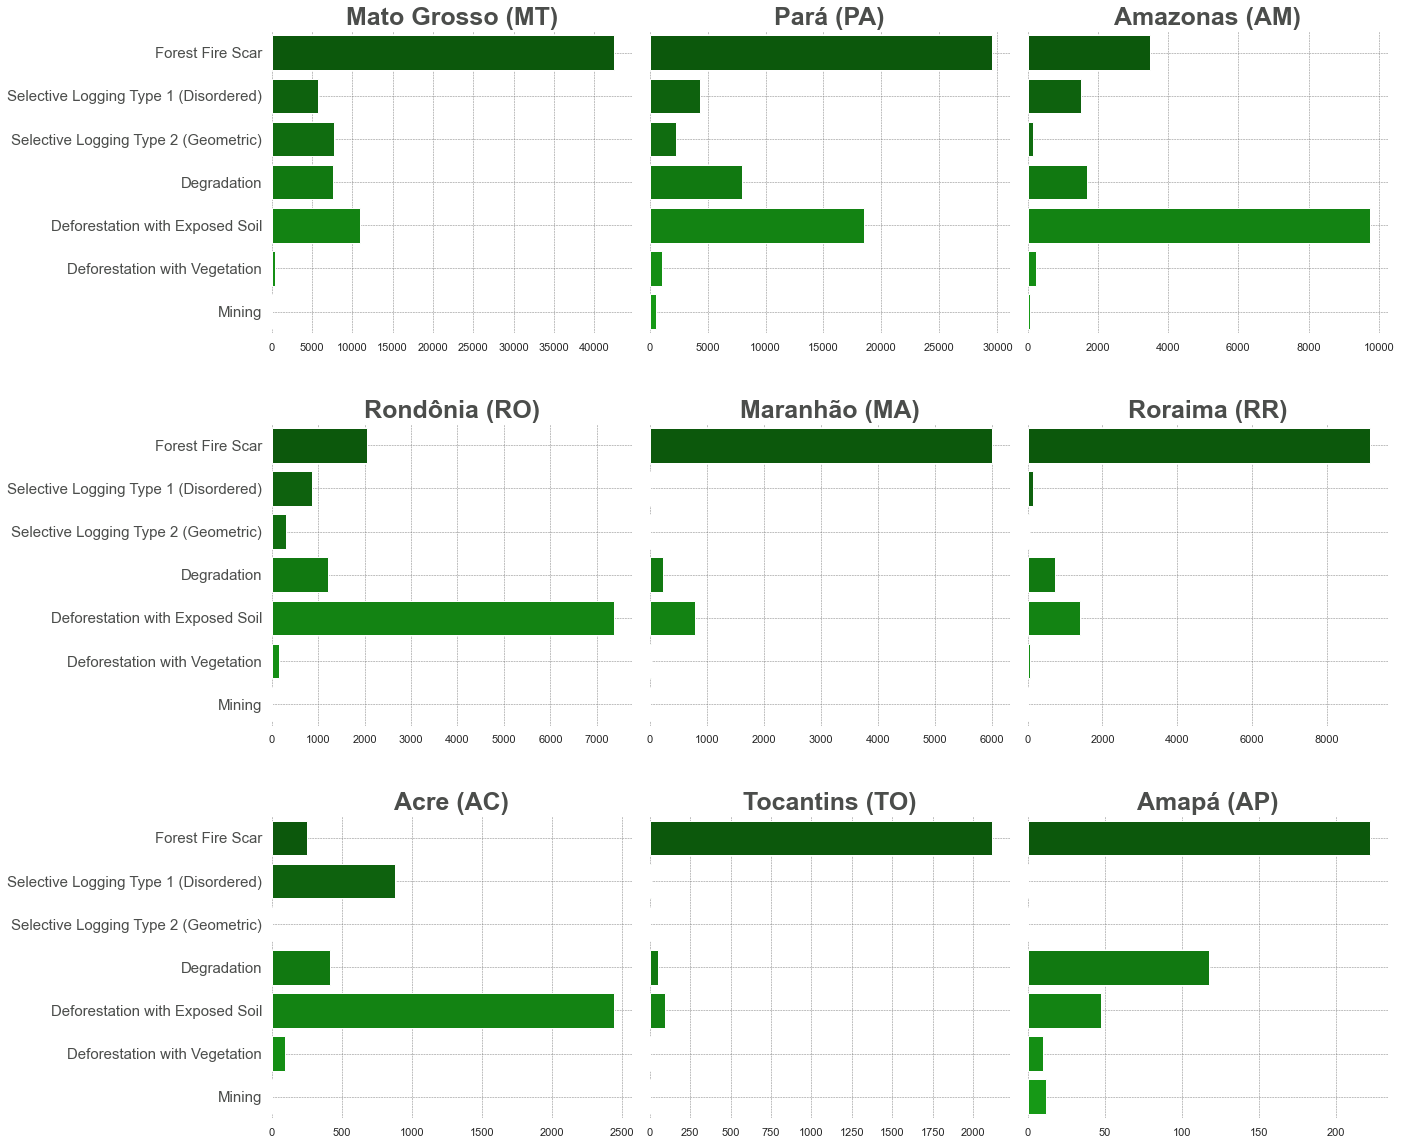

In [29]:
dict_classes, texts = get_texts("English")
save_graph("Graph8_EN",deter_graph8)

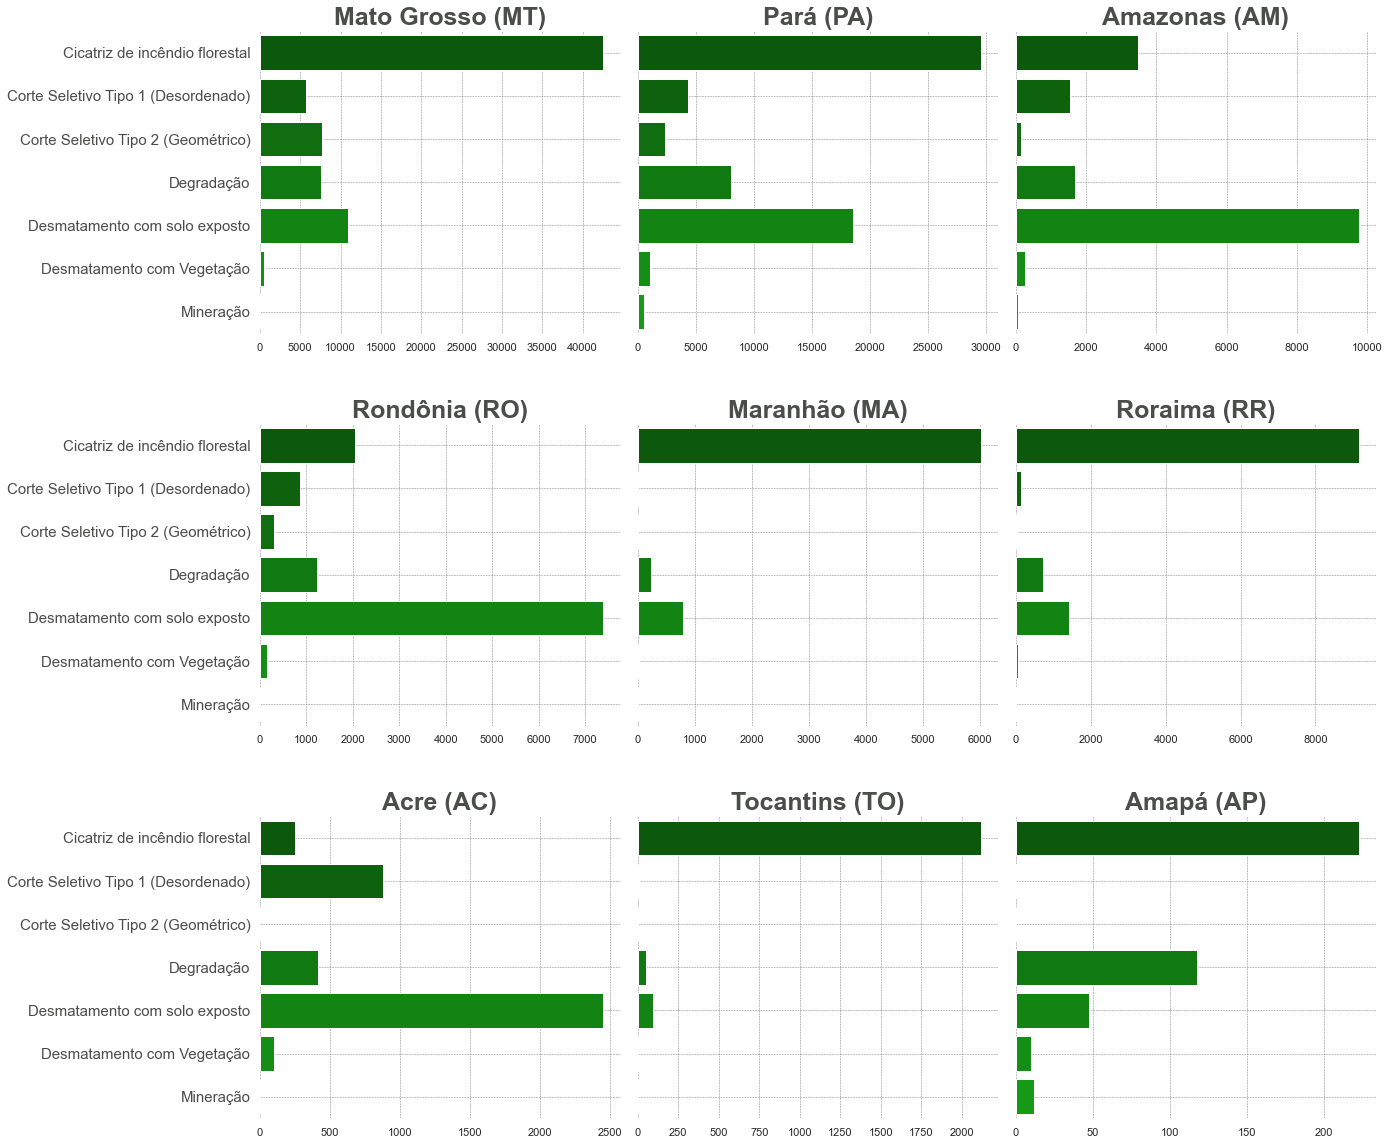

In [30]:
dict_classes, texts = get_texts("Portuguese")
save_graph("Graph8_PT",deter_graph8)

### Graph 9:

In [31]:
def deter_graph9():
    sum_areamunkm = df_deter.groupby('UC')['AREAMUNKM'].sum().reset_index()
    info_uc = df_deter.drop_duplicates(subset='UC')[['UC', 'UF', 'MUNICIPALI']]
    res = pd.merge(sum_areamunkm, info_uc, on='UC', how='left')
    top_ucs = res.sort_values(by='AREAMUNKM', ascending=False).head(25)
    top_ucs['UC/LOC'] = top_ucs['UC'] + ' (' + top_ucs['MUNICIPALI'].str.upper() + '/' + top_ucs['UF'].str.upper() + ')'

    fig, ax = plt.subplots(figsize=(8,14))
    sns.set_theme(style="white")
    ax = sns.barplot(data=top_ucs, x=top_ucs.AREAMUNKM, y = top_ucs['UC/LOC'],
                     palette=palette_gen(n_colors=top_ucs.shape[0]))
    #ax.set_title(texts['graph9_title'], fontsize=20, color=gray, fontweight='bold');
    #fig.suptitle(texts['graph9_title'], fontsize=23, color=gray, fontweight='bold', horizontalalignment='center',x=0.28,y=0.92)
    ax.set_xlabel('');
    ax.set_ylabel('');
    ax.set_xticklabels([]);
    ax.yaxis.set_tick_params(labelsize=10, labelcolor = gray)
    sns.despine(left = True, bottom = True)

    for i, valor in enumerate(top_ucs.AREAMUNKM):
        qtd = f'{valor:,.0f} km²'.replace(',','.')  

        offset = 110

        if valor>100:
            offset = 125

        if valor>200:
            offset = 130
        
        if valor>1000:
            offset = 150
        
        
        ax.text(valor + offset, i, qtd, color= gray, fontsize=12, fontweight='bold', ha='right', va='center')

    return fig, ax

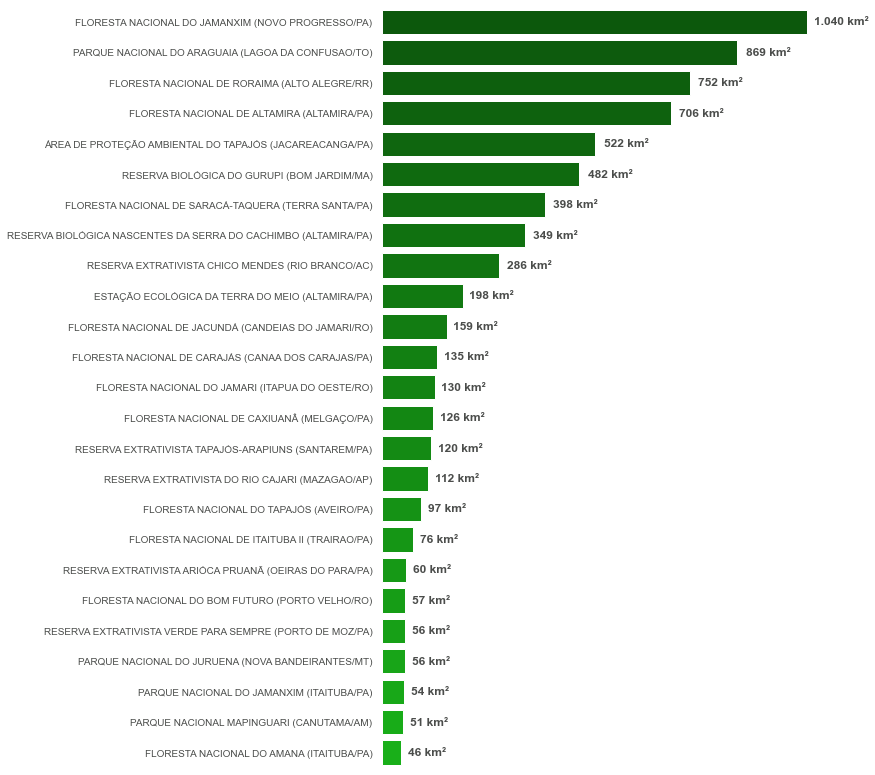

In [32]:
dict_classes, texts = get_texts("English")
save_graph("Graph9_EN",deter_graph9)

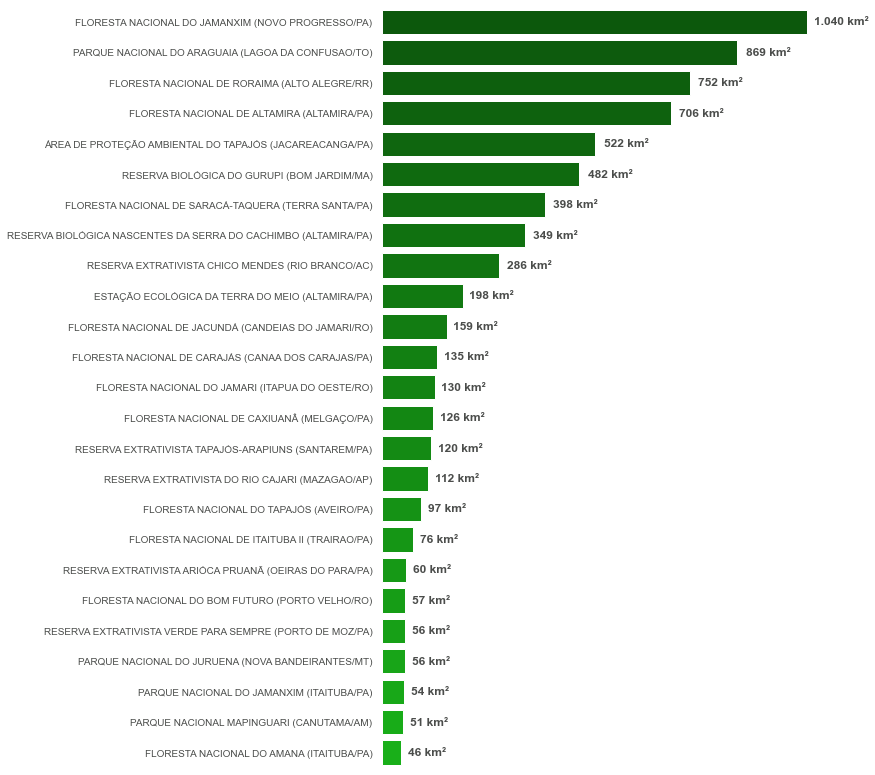

In [33]:
dict_classes, texts = get_texts("Portuguese")
save_graph("Graph9_PT",deter_graph9)